# Import Dataset

In [11]:
import gc
gc.collect()
import subprocess as sp
import os
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

[11170]

In [12]:
import json
from nltk.corpus import stopwords
import re
import json
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
with open('test_dataset.json', 'r') as fp:
    test_dataset = json.load(fp)
with open('train_dataset.json', 'r') as fp:
    train_dataset = json.load(fp)
f = open('/data/data_codebook.json')
data_codebook = json.load(f)
super_set={}
for s in data_codebook:
    if s[2]!="domain_name":
        if s[2] not in super_set:
            super_set[s[2]]=[]
        if s[5] not in super_set[s[2]]:
            super_set[s[2]].append(s[5])

In [13]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [14]:
def calculate_dataset_counts(dataset):
    count_dataset = {
        "general": {},
        "detailed": {}
    }
    
    for s in dataset:
        detailed_label = s['detailed_label']
        general_label = s["general_label"]
        
        if detailed_label not in count_dataset["detailed"]:
            count_dataset["detailed"][detailed_label] = 0
        count_dataset["detailed"][detailed_label] += 1

        if general_label not in count_dataset["general"]:
            count_dataset["general"][general_label] = 0
        count_dataset["general"][general_label] += 1
    
    return count_dataset

In [15]:
def create_custom_dataset(balanced_dataset, total_limit, desired_percentage):
    used_sentences = set()
    dataset = []
    super_category_counts = {super_category: 0 for super_category in super_set.keys()}
    category_counts = {category: 0 for category in balanced_dataset.keys()}

    # Calculate the limit for 'Welfare and Quality of Life' based on desired_percentage
    welfare_category = 'Welfare and Quality of Life'
    welfare_desired_limit = int(total_limit * desired_percentage)
    # Calculate the total number of sentences in the 'Welfare and Quality of Life' super-category
    welfare_super_category_sentences = sum(len(balanced_dataset[category]) for category in super_set[welfare_category] if category in balanced_dataset)
    # Calculate the limits for categories within the 'Welfare and Quality of Life' super-category
    welfare_category_limits = {}
    for category in super_set[welfare_category]:
        if category in balanced_dataset:
            category_percentage = len(balanced_dataset[category]) / welfare_super_category_sentences
            welfare_category_limits[category] = int(welfare_desired_limit * category_percentage)
    
    # Process 'Welfare and Quality of Life' category first
    welfare_categories = super_set[welfare_category]
    #print(welfare_super_category_sentences)
    for category in welfare_categories:
        if category not in balanced_dataset:
            continue
        
        sentences = balanced_dataset[category]
        category_limit = welfare_category_limits[category]
        for sentence in sentences:
            if len(dataset) >= welfare_desired_limit or len(dataset) >= total_limit:
                break

            if sentence not in used_sentences and super_category_counts[welfare_category] < welfare_desired_limit and category_limit > 0:
                per_line_dict = {
                    "sentence": sentence,
                    "detailed_label": category,
                    "general_label": welfare_category
                }
                dataset.append(per_line_dict)
                used_sentences.add(sentence)
                super_category_counts[welfare_category] += 1
                category_limit -= 1    
                
    def get_max_value_key_and_value(dictionary):
        max_key = max(dictionary, key=dictionary.get)
        max_value = dictionary[max_key]
        return max_key, max_value
    
    if len(dataset)<welfare_desired_limit:
        w_max_key, w_max_value=get_max_value_key_and_value(welfare_category_limits)
        missing_part=welfare_desired_limit-len(dataset)
        for sentence in balanced_dataset[w_max_key]:
            if  missing_part>0:
                if sentence not in used_sentences and super_category_counts[welfare_category] < welfare_desired_limit:
                    per_line_dict = {
                        "sentence": sentence,
                        "detailed_label": w_max_key,
                        "general_label": welfare_category
                    }
                    dataset.append(per_line_dict)
                    used_sentences.add(sentence)
                    super_category_counts[welfare_category] += 1
                    missing_part-= 1
    # Calculate the limit for other super categories
    other_desired_limit = total_limit - welfare_desired_limit
    
    def get_length(d):
        ''' Return length of all dict values'''
        return sum(len(v) for k, v in d.items())
    
    total_length=get_length(balanced_dataset)
    non_welfare_sentences_count=total_length-welfare_super_category_sentences
    non_welfare_category_limits = {}
    for super_category, categories in super_set.items(): 
        if super_category==welfare_category:
            continue
        for category in categories:
            if category not in balanced_dataset:
                continue
            non_welfare_category_percentage = len(balanced_dataset[category]) / non_welfare_sentences_count
            non_welfare_category_limits[category] = int(other_desired_limit * non_welfare_category_percentage)
    for super_category, categories in super_set.items(): 
        if super_category==welfare_category:
            continue
            
        for category in categories:
            if category not in balanced_dataset:
                continue
            sentences = balanced_dataset[category]
            category_limit = non_welfare_category_limits[category]
            for sentence in sentences:
                
                if sentence not in used_sentences and super_category_counts[super_category] < other_desired_limit and category_limit > 0:
                    
                    per_line_dict = {
                        "sentence": sentence,
                        "detailed_label": category,
                        "general_label": super_category
                    }
                    dataset.append(per_line_dict)
                    used_sentences.add(sentence)
                    super_category_counts[super_category] += 1
                    category_limit -= 1
    
    if len(dataset)< total_limit:
        wn_max_key, wn_max_value=get_max_value_key_and_value(non_welfare_category_limits)
        for super_category, categories in super_set.items(): 
            if wn_max_key in categories:
                additional_super_category=super_category
        missing_part=total_limit-len(dataset)
        for sentence in balanced_dataset[wn_max_key]:
            if  missing_part>0:
                if sentence not in used_sentences:
                    per_line_dict = {
                        "sentence": sentence,
                        "detailed_label": wn_max_key,
                        "general_label": additional_super_category
                    }
                    dataset.append(per_line_dict)
                    used_sentences.add(sentence)
                    super_category_counts[additional_super_category] += 1
                    missing_part-= 1
    return dataset

In [16]:
"Experiment 1"
total_limit = 56000
desired_percentage = 0.5

dataset = create_custom_dataset(train_dataset, total_limit, desired_percentage)

print("Total sentences in the dataset:", len(dataset))

# Usage example:
# Assuming you have the 'dataset' variable containing the dataset obtained from the create_custom_dataset function
# Replace this with the actual dataset you want to count.
count_dataset = calculate_dataset_counts(dataset)
print(count_dataset["general"])
print(sum(count_dataset["general"].values()))
print(len(count_dataset["detailed"].keys()))
print(count_dataset["detailed"])

Total sentences in the dataset: 56000
{'Welfare and Quality of Life': 28000, 'External Relations': 3263, 'Freedom and Democracy': 2662, 'Political System': 4201, 'Economy': 10878, 'Fabric of Society': 4772, 'Social Groups': 2224}
56000
97
{'Environmental Protection': 4028, 'Culture: Positive': 3294, 'Equality: Positive': 6094, 'Welfare State Expansion': 9582, 'Welfare State Limitation': 512, 'Education Expansion': 4413, 'Education Limitation': 49, 'Private-Public Mix in Culture: Positive': 3, 'Private-Public Mix in Welfare: Positive': 21, 'Private-Public Mix in Education: Positive': 4, 'Foreign Special Relationships: Positive': 119, 'Foreign Special Relationships: Negative': 42, 'Anti-Imperialism': 19, 'Military: Positive': 672, 'Military: Negative': 161, 'Peace': 165, 'Internationalism: Positive': 1109, 'European Community/Union: Positive': 673, 'Internationalism: Negative': 80, 'European Community/Union: Negative': 185, 'Russia/USSR/CIS: Positive': 1, 'SFR Yugoslavia: Positive': 2, '

# RoBerta model

In [17]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [18]:
dataframe = pd.DataFrame(data=(dataset))
dataframe=shuffle(dataframe).dropna()
dataframe

,sentence,detailed_label,general_label
5750,The Party for a European Future (PEI) will ad...,Culture: Positive,Welfare and Quality of Life
24333,Management of the school calendar;,Education Expansion,Welfare and Quality of Life
41335,Qualifications of the existing housing stock ...,Economic Planning,Economy
47741,The ecological footprint is a new method for ...,Anti-Growth Economy: Positive,Economy
48172,"In any case, more clarity must be provided wi...",Sustainability: Positive,Economy
...,...,...,...
26025,Cooperation on innovation and science,Education Expansion,Welfare and Quality of Life
26323,We will support its openness and integration ...,Education Expansion,Welfare and Quality of Life
55154,The co-payment is indeed more important for t...,Middle Class and Professional Groups,Social Groups
49570,Mothers take care of children at home signifi...,Traditional Morality: Positive,Fabric of Society


In [19]:
train_sentences=list(dataframe["sentence"])
train_labels=[]
for s in list(dataframe["general_label"]):
    if s=='Welfare and Quality of Life':
        number=1
    else:
        number=0
    train_labels.append(number)

train_sentences_cleaned=[]
for s in list(dataframe["sentence"]):
    cleaned=clean_text(s)
    train_sentences_cleaned.append(cleaned)

max:  135
min:  2


Text(0.5, 1.0, 'The distribution of sequence length, when the percentage of Welfare sentences is: 50.0%')

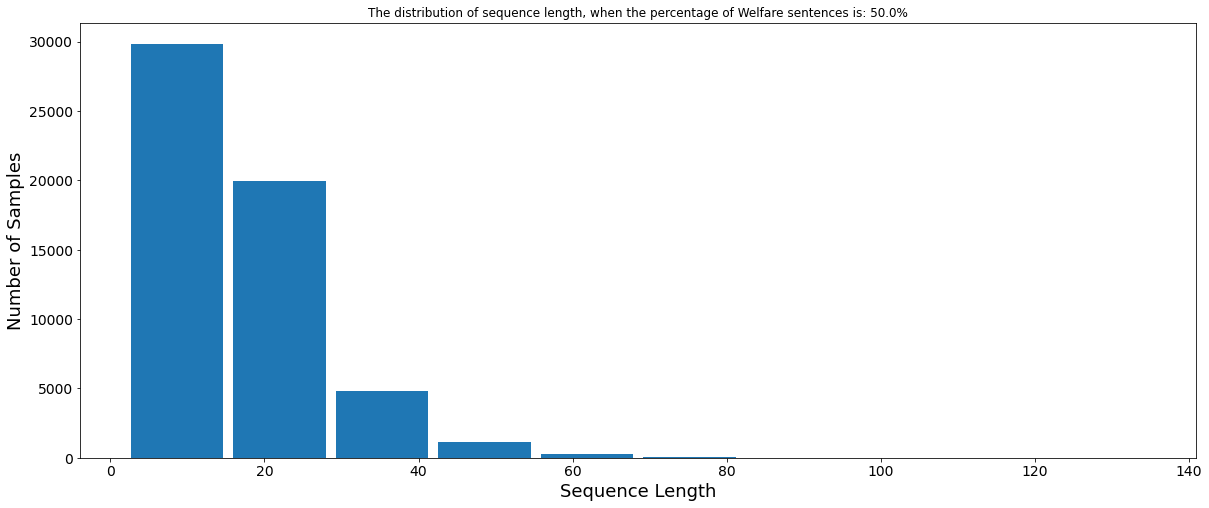

In [20]:
# tokenize the text feature 
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            train_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Number of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("The distribution of sequence length, when the percentage of Welfare sentences is: "+str(desired_percentage*100)+"%")

In [21]:
# tokenize features 
MAX_LEN = 135
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            train_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt')

In [22]:
# Use 80% for training and 20% for validation
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(tokenized_feature['input_ids'], 
                                                                                                             train_labels,
                                                                                                                    tokenized_feature['attention_mask'],
                                                                                                      random_state=42, test_size=0.2, stratify=train_labels)

In [23]:
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [24]:
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [25]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = len(set(train_labels)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Receive the full size of the new word
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 250002. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(250002, 768, padding_idx=1)

In [27]:
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

/home/users/yabdul/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
# Number of training epochs
epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [46]:
# tell pytorch to run this model on GPU
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [1]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

NameError: name 'torch' is not defined

In [30]:
# Function to calculate the accuracy of our predictions vs labels
import time
import datetime
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
torch.cuda.empty_cache()
# start training from here

In [49]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'Roberta_50percent_TwoStep_General')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.53
  Training epcoh took: 0:12:24

Running Validation...
  Accuracy: 0.78

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.46
  Training epcoh took: 0:12:23

Running Validation...
  Accuracy: 0.79

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.41
  Training epcoh took: 0:12:24

Running Validation...
  Accuracy: 0.79

Training complete!
Total training took 0:40:49 (h:mm:ss)


In [31]:
model = torch.load('Roberta_50percent_TwoStep_General')

# Test the model

In [32]:
print("-----Now test the model on another unseen test sets--------")
test_dataframe=[]
for k,v in test_dataset.items():
    for key, value in super_set.items():
        if k in value:
            super_label = key
    for s in v:
            per_line_dict = {}
            per_line_dict["sentence"] = s
            per_line_dict["detailed_label"] = k
            per_line_dict["general_label"] = super_label
            test_dataframe.append(per_line_dict)

test_dataframe = pd.DataFrame(data=(test_dataframe))
test_dataframe=shuffle(test_dataframe).dropna()
test_dataframe

-----Now test the model on another unseen test sets--------


,sentence,detailed_label,general_label
32320,"1. Clear division of functions, competences a...",Culture: Positive,Welfare and Quality of Life
67177,"Because of this, there is a great pressure of...",Economic Growth: Positive,Economy
13601,We believe that tax policy can and should be u...,Incentives: Positive,Economy
83142,"We reject capitalism, which is in line with t...",Internationalism: Negative,External Relations
17192,while incorporating clear conditionality for ...,Economic Orthodoxy,Economy
...,...,...,...
69315,While our country has risen to the top catego...,Democracy General: Positive,Freedom and Democracy
8931,The Center Party will secure and develop this...,Nationalisation,Economy
35872,"Only a corrupt, moral, law-abiding public spi...",Law and Order: Positive,Fabric of Society
62620,We enacted the Banking Law in order to ensure...,Political Corruption,Political System


In [33]:
test_sentences_cleaned=[]
for s in list(test_dataframe["sentence"]):
    cleaned=clean_text(s)
    test_sentences_cleaned.append(cleaned)

test_labels_numbers=[]
for s in list(test_dataframe["general_label"]):
    if s=='Welfare and Quality of Life':
        number=1
    else:
        number=0
    test_labels_numbers.append(number)

In [34]:
len(test_sentences_cleaned)==len(test_labels_numbers)

True

max:  151
min:  2


Text(0.5, 1.0, 'Test set.The distribution of sequence length, when the percentage of Welfare sentences is: 50.0%')

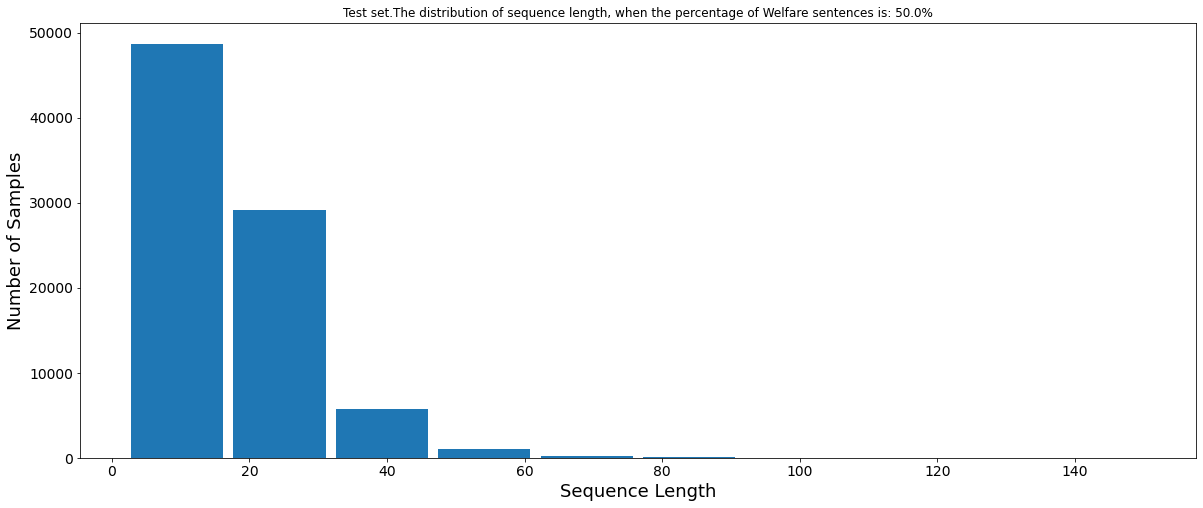

In [35]:
# tokenize the text feature 
test_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            test_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in test_tokenized_feature['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Number of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Test set.The distribution of sequence length, when the percentage of Welfare sentences is: "+str(desired_percentage*100)+"%")

In [36]:
# tokenize features 
MAX_LEN = 151
test_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            test_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'     )

In [37]:
# Create the DataLoader for our test set
validation_data = TensorDataset(test_tokenized_feature['input_ids'], test_tokenized_feature['attention_mask'], torch.tensor(test_labels_numbers))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [38]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 467.57 s


In [39]:
# convert numeric label to string
final_prediction_list = np.concatenate(predictions)
# Evaluate accuracy
accuracy = accuracy_score(test_labels_numbers, final_prediction_list)

# Evaluate F1-score
f1_score = f1_score(test_labels_numbers, final_prediction_list, average='weighted')

# Evaluate balanced accuracy
balanced_accuracy = balanced_accuracy_score(test_labels_numbers, final_prediction_list)


# Print evaluation metrics for Linear SVC on the unseen test set
print("Linear SVC Accuracy on Unseen Test Set:", round(accuracy,2))
print("Linear SVC F1-Score on Unseen Test Set:", round(f1_score,2))
print("Linear SVC Balanced Accuracy on Unseen Test Set:", round(balanced_accuracy,2))
print()

# Print classification report and confusion matrix for Linear SVC on the unseen test set
print("Linear SVC Classification Report on Unseen Test Set:")
print(classification_report(test_labels_numbers, final_prediction_list))

print("Linear SVC Confusion Matrix on Unseen Test Set:")
print(confusion_matrix(test_labels_numbers, final_prediction_list))

Linear SVC Accuracy on Unseen Test Set: 0.78
Linear SVC F1-Score on Unseen Test Set: 0.79
Linear SVC Balanced Accuracy on Unseen Test Set: 0.78

Linear SVC Classification Report on Unseen Test Set:
              precision    recall  f1-score   support

           0       0.87      0.78      0.83     55471
           1       0.66      0.79      0.72     29389

    accuracy                           0.78     84860
   macro avg       0.77      0.78      0.77     84860
weighted avg       0.80      0.78      0.79     84860

Linear SVC Confusion Matrix on Unseen Test Set:
[[43378 12093]
 [ 6241 23148]]
